# Fruit classification

## Data analysis and preprocessing

The purpose of this project is to correctly classify a set of images showing five different types of fruits using a CNN approach with various pre-trained models.

### Checks on the data

Importing various libraries for further use

In [1]:
from PIL import Image
import glob as gb
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as skmet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPool2D, GlobalAveragePooling2D, Reshape, Rescaling, MaxPooling2D, Dropout, AveragePooling2D, RandomRotation, RandomCrop, RandomZoom, RandomContrast, ZeroPadding2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
import efficientnet.keras as efn

Defining a data pipeline for preprocessing. It's important to remember that some work has already been performed to create a folder for training, validation and test, with corresponding subfolders for each class, derived from the raw class folders.


Starting with definition of the data path (folder where the data are stored).


In [4]:
train_path = 'data/train/'
test_path = 'data/test/'
val_path = 'data/valid/'

Verifying the distribution of data with respect to the labels, starting from the train data, this have a crucial role in preventing an unbalanced training process.

for training data , found 1400 in folder Apple
for training data , found 1400 in folder Banana
for training data , found 1400 in folder Grape
for training data , found 1400 in folder Mango
for training data , found 1400 in folder Strawberry


Text(0.5, 1.0, 'Train examples distribution')

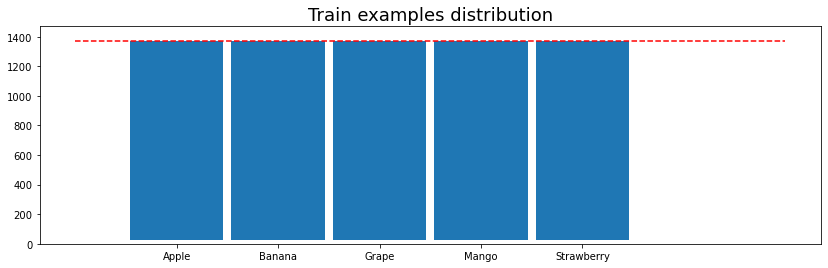

In [5]:
train_len = {}

for folder in os.listdir(train_path):
    files = gb.glob(pathname=str(train_path+folder + "/*.jpeg"))
    train_len[folder] = len(files)
    print(f"for training data , found {len(files)} in folder {folder}")

fig, ax = plt.subplots(figsize=(14,4))
train_len_list = [key for key, val in train_len.items() for _ in range(val)]
ax.hist(train_len_list, bins=np.arange(0, 6)-.5, edgecolor='white', linewidth=8, align="mid")
ax.hlines(1370, -1, 6, linestyles='--', color='r')
ax.set_title('Train examples distribution', fontsize=18)

Repeating the process for validation

for test data , found 300 in folder Apple
for test data , found 300 in folder Banana
for test data , found 300 in folder Grape
for test data , found 300 in folder Mango
for test data , found 300 in folder Strawberry


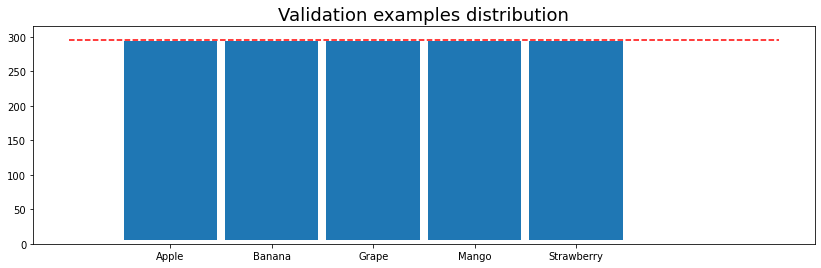

In [6]:
val_len = {}
for folder in os.listdir(val_path):
    files = gb.glob(pathname=str(val_path+folder + "/*.jpeg"))
    val_len[folder] = len(files)
    print(f"for test data , found {len(files)} in folder {folder}")

fig, ax = plt.subplots(figsize=(14,4))
test_len_list = [key for key, val in val_len.items() for _ in range(val)]
ax.hist(test_len_list, bins=np.arange(0, 6)-.5, edgecolor='white', linewidth=8, align="mid")
ax.hlines(295, -1, 6, linestyles='--', color='r')
ax.set_title('Validation examples distribution', fontsize=18)

plt.show()

And again for the test data

for test data , found 300 in folder Apple
for test data , found 300 in folder Banana
for test data , found 300 in folder Grape
for test data , found 300 in folder Mango
for test data , found 300 in folder Strawberry


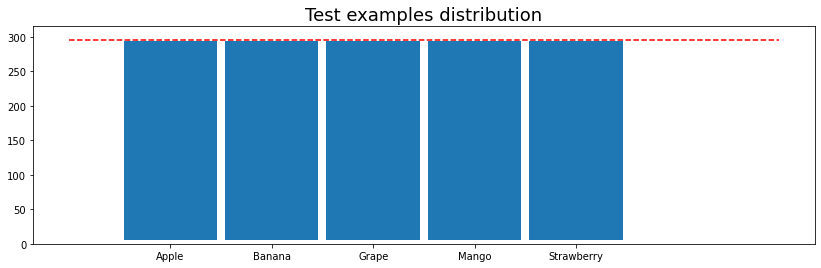

In [7]:
test_len = {}
for folder in os.listdir(test_path):
    files = gb.glob(pathname=str(test_path+folder + "/*.jpeg"))
    test_len[folder] = len(files)
    print(f"for test data , found {len(files)} in folder {folder}")

fig, ax = plt.subplots(figsize=(14,4))
test_len_list = [key for key, val in test_len.items() for _ in range(val)]
ax.hist(test_len_list, bins=np.arange(0, 6)-.5, edgecolor='white', linewidth=8, align="mid")
ax.hlines(295, -1, 6, linestyles='--', color='r')
ax.set_title('Test examples distribution', fontsize=18)

plt.show()


Checking that the images can be visualized correctly by choosing an image for each classes of train set.

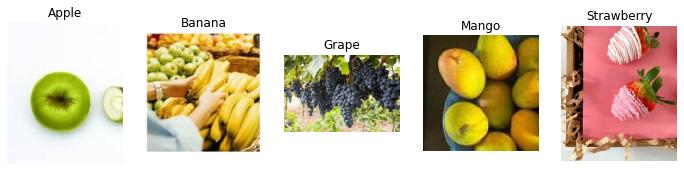

In [8]:
fig, axs = plt.subplots(1,5,figsize=(12,4))

img = []
for i, folder in enumerate(os.listdir(train_path)):
    ax = axs.ravel()[i]
    files = gb.glob(pathname=str(train_path+folder + "/*.jpeg"))
    img.append(plt.imread(files[0]))
    ax.set_title(folder)
    ax.axis('off')
    ax.imshow(img[i])

Checking the height and the width of the images to evaluate the initial dimension of the data, which may be adjusted based on specific requirements (like model ones).

In [9]:
paths=[train_path, test_path]
height = []
width = []
for path in paths:
    for folder in os.listdir(train_path):
        files = gb.glob(pathname=str(train_path+folder + "/*.jpeg"))
        for file in files:
            im = Image.open(file)
            width.append(im.size[0])
            height.append(im.size[1])

Plotting previous information in histograms to visualize it.

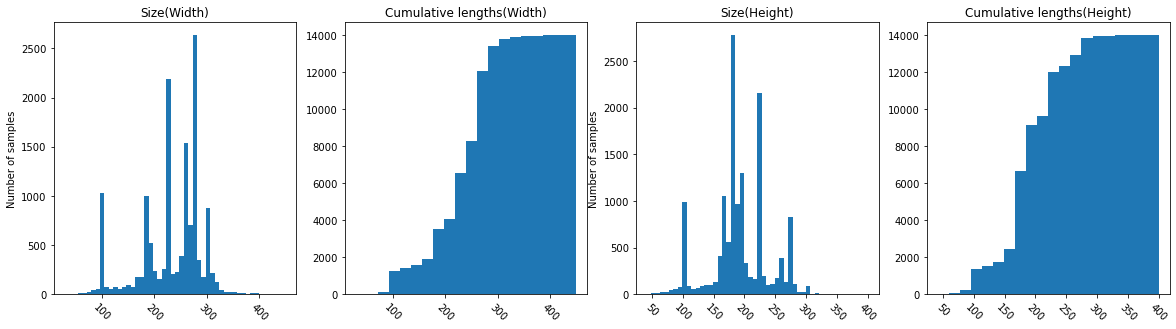

In [10]:
images_size = [width, height]
size_labels = ['Width','Width', 'Height', 'Height']
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i, size in enumerate(images_size):
    if i == 1:
        i+=1
    ax = axs.ravel()[i]
    ax.hist(size, bins=50)
    ax.set_title(f"Size({size_labels[i]})")
    ax.set_ylabel("Number of samples")
    ax.tick_params('x', labelrotation=-45)
    ax = axs.ravel()[i+1]
    ax.hist(size, bins=20, cumulative=True)
    ax.set_title(f"Cumulative lengths({size_labels[i]})")
    ax.tick_params('x', labelrotation=-45)

### Preprocessing the data

Setting some hyperparameters such as image size, based on model desired input size and batch size to be used during the model training(gradient update).

The vector _im_size_ only contains two sizes because 2 out of the 3 models share it.

In [11]:
im_size = ((224, 224), (150, 150))
batch_size = 128

Processing images to get tensorflow tensors, starting from the training set and taking the first element of _im_size_ for the first two models and then the second element for the third one.

In [12]:
train_data0 = tf.keras.utils.image_dataset_from_directory(train_path, seed=123, image_size=im_size[0], batch_size=batch_size)
train_data1 = tf.keras.utils.image_dataset_from_directory(train_path, seed=123, image_size=im_size[1], batch_size=batch_size)

Found 7000 files belonging to 5 classes.
Found 7000 files belonging to 5 classes.


Repeating the process for the validation data.

In [13]:
validation_data0 = tf.keras.utils.image_dataset_from_directory(val_path, seed=123, image_size=im_size[0], batch_size=batch_size)
validation_data1 = tf.keras.utils.image_dataset_from_directory(val_path, seed=123, image_size=im_size[1], batch_size=batch_size)
    

Found 1500 files belonging to 5 classes.
Found 1500 files belonging to 5 classes.


Performing the same process with the test data, with some differences due the purpose of test set(no shuffling and unique batch)

In [14]:
test_data0 = tf.keras.utils.image_dataset_from_directory(test_path, image_size=im_size[0], batch_size=1, shuffle=False)
test_data1 = tf.keras.utils.image_dataset_from_directory(test_path, image_size=im_size[1], batch_size=1, shuffle=False)

Found 1500 files belonging to 5 classes.
Found 1500 files belonging to 5 classes.


Setting other hyperparameters learned during the processing step just completed.

In [15]:
class_names = train_data0.class_names
n_classes = len(class_names)

Verifying the image visualization again after the resizing process, taking them from the first batch of the first training set.

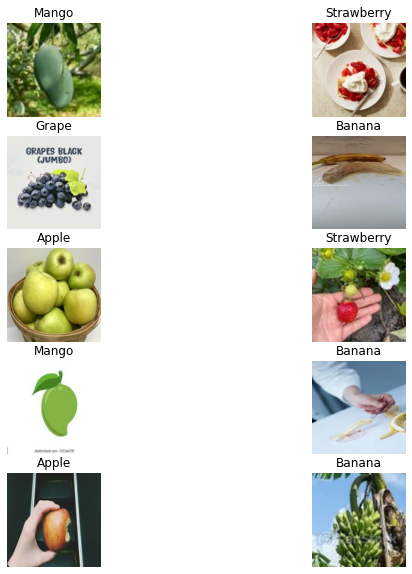

In [16]:
plt.figure(figsize=(10, 10))

for images, labels in train_data0.take(1):
    for i in range(10):
        ax = plt.subplot(5, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Rescaling the value of the pixel values of the image between 0 and 1, this process is crucial during the training. Performing the normalization first for the training set, and then proceeding with the validation and test sets.

In [17]:
def normalize_image(image, label):
    return tf.cast(image, tf.float32) / 255., label

train_data0 = train_data0.map(normalize_image)
train_data1 = train_data1.map(normalize_image)
validation_data0 = validation_data0.map(normalize_image)
validation_data1 = validation_data1.map(normalize_image)
test_data0 = test_data0.map(normalize_image)
test_data1 = test_data1.map(normalize_image)

### Setting model structure

Defining different types of model structure, the aim of this part is simply import pre-trained models and freeze the convolutional blocks, in order to proceed with fine-tuning on the last added layers.

Starting with the first model, the _VGG16_.

In [18]:
base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

Adding layers to the model to train for the specific task of classification.

In [19]:
# Flatten the output layer to 1 dimension
x = Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.5
x = Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
output = Dense(n_classes, activation='softmax', name='OutputLayer')(x)

model1 = tf.keras.models.Model(base_model.input, output, name='Fruitclassificator_VGG16')


Summarizing the model structure to check which layers are trainable or not and the number of parameters involved.

In [20]:
model1.summary(show_trainable=True)

Model: "Fruitclassificator_VGG16"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         N          
                                                                            
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      N          
                                                                            
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     N          
                                                                            
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         N          
                                                                            
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     N          
                                                                            
 block2_conv2 (Conv2D)       (None, 112, 1

Taking into account the second model, the _InceptionV3_. It will take the second image size previous defined.

In [21]:
base_model = InceptionV3(input_shape = (150, 150, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

Adding again some layers at the end of the convolutional blocks.

In [22]:
x = Flatten()(base_model.output)

x = Dense(1024, activation='relu')(x)

x = Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
output = Dense(n_classes, activation='softmax', name='OutputLayer')(x)

model2 = tf.keras.models.Model(base_model.input, output, name='Fruitclassificator_InceptionV3')

Summarizing the second model.

In [23]:
model2.summary(show_trainable=True)

Model: "Fruitclassificator_InceptionV3"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               N          
                                )]                                                                           
                                                                                                             
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_2[0][0]']                N          
                                                                                                             
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 N          
 alization)                                                                     

 conv2d_11 (Conv2D)             (None, 16, 16, 32)   6144        ['average_pooling2d[0][0]']      N          
                                                                                                             
 batch_normalization_5 (BatchNo  (None, 16, 16, 64)  192         ['conv2d_5[0][0]']               N          
 rmalization)                                                                                                
                                                                                                             
 batch_normalization_7 (BatchNo  (None, 16, 16, 64)  192         ['conv2d_7[0][0]']               N          
 rmalization)                                                                                                
                                                                                                             
 batch_normalization_10 (BatchN  (None, 16, 16, 96)  288         ['conv2d_10[0][0]']              N          
 ormalizat

                                                                                                             
 activation_12 (Activation)     (None, 16, 16, 64)   0           ['batch_normalization_12[0][0]'  N          
                                                                 ]                                           
                                                                                                             
 activation_14 (Activation)     (None, 16, 16, 64)   0           ['batch_normalization_14[0][0]'  N          
                                                                 ]                                           
                                                                                                             
 activation_17 (Activation)     (None, 16, 16, 96)   0           ['batch_normalization_17[0][0]'  N          
                                                                 ]                                           
          

                                                                 ]                                           
                                                                                                             
 mixed2 (Concatenate)           (None, 16, 16, 288)  0           ['activation_19[0][0]',          N          
                                                                  'activation_21[0][0]',                     
                                                                  'activation_24[0][0]',                     
                                                                  'activation_25[0][0]']                     
                                                                                                             
 conv2d_27 (Conv2D)             (None, 16, 16, 64)   18432       ['mixed2[0][0]']                 N          
                                                                                                             
 batch_nor

                                                                 ]                                           
                                                                                                             
 conv2d_32 (Conv2D)             (None, 7, 7, 128)    114688      ['activation_31[0][0]']          N          
                                                                                                             
 conv2d_37 (Conv2D)             (None, 7, 7, 128)    114688      ['activation_36[0][0]']          N          
                                                                                                             
 batch_normalization_32 (BatchN  (None, 7, 7, 128)   384         ['conv2d_32[0][0]']              N          
 ormalization)                                                                                               
                                                                                                             
 batch_nor

                                                                                                             
 conv2d_46 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_45[0][0]']          N          
                                                                                                             
 batch_normalization_41 (BatchN  (None, 7, 7, 160)   480         ['conv2d_41[0][0]']              N          
 ormalization)                                                                                               
                                                                                                             
 batch_normalization_46 (BatchN  (None, 7, 7, 160)   480         ['conv2d_46[0][0]']              N          
 ormalization)                                                                                               
                                                                                                             
 activatio

                                                                                                             
 activation_54 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_54[0][0]'  N          
                                                                 ]                                           
                                                                                                             
 conv2d_55 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_54[0][0]']          N          
                                                                                                             
 batch_normalization_55 (BatchN  (None, 7, 7, 160)   480         ['conv2d_55[0][0]']              N          
 ormalization)                                                                                               
                                                                                                             
 activatio

                                                                                                             
 activation_59 (Activation)     (None, 7, 7, 192)    0           ['batch_normalization_59[0][0]'  N          
                                                                 ]                                           
                                                                                                             
 mixed6 (Concatenate)           (None, 7, 7, 768)    0           ['activation_50[0][0]',          N          
                                                                  'activation_53[0][0]',                     
                                                                  'activation_58[0][0]',                     
                                                                  'activation_59[0][0]']                     
                                                                                                             
 conv2d_64

 ormalization)                                                                                               
                                                                                                             
 batch_normalization_69 (BatchN  (None, 7, 7, 192)   576         ['conv2d_69[0][0]']              N          
 ormalization)                                                                                               
                                                                                                             
 activation_60 (Activation)     (None, 7, 7, 192)    0           ['batch_normalization_60[0][0]'  N          
                                                                 ]                                           
                                                                                                             
 activation_63 (Activation)     (None, 7, 7, 192)    0           ['batch_normalization_63[0][0]'  N          
          

                                                                                                             
 conv2d_80 (Conv2D)             (None, 3, 3, 448)    573440      ['mixed8[0][0]']                 N          
                                                                                                             
 batch_normalization_80 (BatchN  (None, 3, 3, 448)   1344        ['conv2d_80[0][0]']              N          
 ormalization)                                                                                               
                                                                                                             
 activation_80 (Activation)     (None, 3, 3, 448)    0           ['batch_normalization_80[0][0]'  N          
                                                                 ]                                           
                                                                                                             
 conv2d_77

                                                                                                             
 concatenate (Concatenate)      (None, 3, 3, 768)    0           ['activation_82[0][0]',          N          
                                                                  'activation_83[0][0]']                     
                                                                                                             
 activation_84 (Activation)     (None, 3, 3, 192)    0           ['batch_normalization_84[0][0]'  N          
                                                                 ]                                           
                                                                                                             
 mixed9 (Concatenate)           (None, 3, 3, 2048)   0           ['activation_76[0][0]',          N          
                                                                  'mixed9_0[0][0]',                          
          

 activation_92 (Activation)     (None, 3, 3, 384)    0           ['batch_normalization_92[0][0]'  N          
                                                                 ]                                           
                                                                                                             
 batch_normalization_93 (BatchN  (None, 3, 3, 192)   576         ['conv2d_93[0][0]']              N          
 ormalization)                                                                                               
                                                                                                             
 activation_85 (Activation)     (None, 3, 3, 320)    0           ['batch_normalization_85[0][0]'  N          
                                                                 ]                                           
                                                                                                             
 mixed9_1 

Completing the definition of the models with the last one, the _EfficientNetB0_.

In [24]:
base_model = efn.EfficientNetB0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

Adding final layers.

In [25]:
# Flatten the output layer to 1 dimension
x = Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.5
x = Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
output = Dense(n_classes, activation='softmax', name='OutputLayer')(x)

model3 = tf.keras.models.Model(base_model.input, output, name='Fruitclassificator_EfficientNetB0')


Checking for the last time the layers structure and their trainability.

In [26]:
model3.summary(show_trainable=True)

Model: "Fruitclassificator_EfficientNetB0"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               N          
                                )]                                                                           
                                                                                                             
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['input_3[0][0]']                N          
                                )                                                                            
                                                                                                             
 stem_bn (BatchNormalization)   (None, 112, 112, 32  128         ['stem_conv[

 lization)                                                                                                   
                                                                                                             
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     N          
                                                                                                             
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    N          
 ization)                                                                                                    
                                                                                                             
 block2b_expand_activation (Act  (None, 56, 56, 144)  0          ['block2b_expand_bn[0][0]']      N          
 ivation)                                                                                                    
          

 block3b_expand_conv (Conv2D)   (None, 28, 28, 240)  9600        ['block3a_project_bn[0][0]']     N          
                                                                                                             
 block3b_expand_bn (BatchNormal  (None, 28, 28, 240)  960        ['block3b_expand_conv[0][0]']    N          
 ization)                                                                                                    
                                                                                                             
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      N          
 ivation)                                                                                                    
                                                                                                             
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][  N          
 D)       

 block4b_expand_bn (BatchNormal  (None, 14, 14, 480)  1920       ['block4b_expand_conv[0][0]']    N          
 ization)                                                                                                    
                                                                                                             
 block4b_expand_activation (Act  (None, 14, 14, 480)  0          ['block4b_expand_bn[0][0]']      N          
 ivation)                                                                                                    
                                                                                                             
 block4b_dwconv (DepthwiseConv2  (None, 14, 14, 480)  4320       ['block4b_expand_activation[0][  N          
 D)                                                              0]']                                        
                                                                                                             
 block4b_b

                                                                                                             
 block5a_expand_conv (Conv2D)   (None, 14, 14, 480)  38400       ['block4c_add[0][0]']            N          
                                                                                                             
 block5a_expand_bn (BatchNormal  (None, 14, 14, 480)  1920       ['block5a_expand_conv[0][0]']    N          
 ization)                                                                                                    
                                                                                                             
 block5a_expand_activation (Act  (None, 14, 14, 480)  0          ['block5a_expand_bn[0][0]']      N          
 ivation)                                                                                                    
                                                                                                             
 block5a_d

                                                                                                             
 block5c_expand_bn (BatchNormal  (None, 14, 14, 672)  2688       ['block5c_expand_conv[0][0]']    N          
 ization)                                                                                                    
                                                                                                             
 block5c_expand_activation (Act  (None, 14, 14, 672)  0          ['block5c_expand_bn[0][0]']      N          
 ivation)                                                                                                    
                                                                                                             
 block5c_dwconv (DepthwiseConv2  (None, 14, 14, 672)  16800      ['block5c_expand_activation[0][  N          
 D)                                                              0]']                                        
          

 ization)                                                                                                    
                                                                                                             
 block6b_expand_activation (Act  (None, 7, 7, 1152)  0           ['block6b_expand_bn[0][0]']      N          
 ivation)                                                                                                    
                                                                                                             
 block6b_dwconv (DepthwiseConv2  (None, 7, 7, 1152)  28800       ['block6b_expand_activation[0][  N          
 D)                                                              0]']                                        
                                                                                                             
 block6b_bn (BatchNormalization  (None, 7, 7, 1152)  4608        ['block6b_dwconv[0][0]']         N          
 )        

 block6d_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6c_add[0][0]']            N          
                                                                                                             
 block6d_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6d_expand_conv[0][0]']    N          
 ization)                                                                                                    
                                                                                                             
 block6d_expand_activation (Act  (None, 7, 7, 1152)  0           ['block6d_expand_bn[0][0]']      N          
 ivation)                                                                                                    
                                                                                                             
 block6d_dwconv (DepthwiseConv2  (None, 7, 7, 1152)  28800       ['block6d_expand_activation[0][  N          
 D)       

 top_bn (BatchNormalization)    (None, 7, 7, 1280)   5120        ['top_conv[0][0]']               N          
                                                                                                             
 top_activation (Activation)    (None, 7, 7, 1280)   0           ['top_bn[0][0]']                 N          
                                                                                                             
 flatten_2 (Flatten)            (None, 62720)        0           ['top_activation[0][0]']         Y          
                                                                                                             
 dense_2 (Dense)                (None, 1024)         64226304    ['flatten_2[0][0]']              Y          
                                                                                                             
 dropout_2 (Dropout)            (None, 1024)         0           ['dense_2[0][0]']                Y          
          

## Training models and evaluating results 

Setting mode of the notebook, if _trainn_ is set on False loading data from model weights stored, else training is available.

In [27]:
trainn = False
if trainn == False:
    model1.load_weights('FruitClassifier_VGG16.h5')
    model2.load_weights('FruitClassifier_InceptionV3.h5')
    model3.load_weights('FruitClassifier_EfficientNetB0.h5')

The task of this section is to finally train the models, one by one and starting from the first one.

Starting setting callbacks for saving best weights during training.

In [28]:
model_save = True
best_w = ModelCheckpoint('FruitClassifier_VGG16.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

Setting the optimizer and the loss function, and then the metrics to track during the process of training.

In [29]:
model1.compile(
  optimizer=tf.optimizers.Adam(learning_rate=0.0001),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

Starting the training of the first model for a number of epochs settled.

In [30]:
if trainn:
    epochs = 10
    if model_save:
        history1 = model1.fit(train_data0,validation_data=validation_data0,epochs=epochs,verbose=1, callbacks=[best_w])
    else:
        history1 = model1.fit(train_data0,validation_data=validation_data0,epochs=epochs,verbose=1)

Epoch 1/10


C:\Users\ASUS\anaconda3\lib\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


55/55 [==============================] - ETA: 0s - loss: 1.1361 - accuracy: 0.5777 
Epoch 1: val_accuracy improved from -inf to 0.73267, saving model to FruitClassifier_VGG16.h5
55/55 [==============================] - 1399s 26s/step - loss: 1.1361 - accuracy: 0.5777 - val_loss: 0.7422 - val_accuracy: 0.7327
Epoch 2/10
55/55 [==============================] - ETA: 0s - loss: 0.6582 - accuracy: 0.7596 
Epoch 2: val_accuracy improved from 0.73267 to 0.74267, saving model to FruitClassifier_VGG16.h5
55/55 [==============================] - 1479s 27s/step - loss: 0.6582 - accuracy: 0.7596 - val_loss: 0.6717 - val_accuracy: 0.7427
Epoch 3/10
55/55 [==============================] - ETA: 0s - loss: 0.5057 - accuracy: 0.8204 
Epoch 3: val_accuracy improved from 0.74267 to 0.77533, saving model to FruitClassifier_VGG16.h5
55/55 [==============================] - 1497s 27s/step - loss: 0.5057 - accuracy: 0.8204 - val_loss: 0.6159 - val_accuracy: 0.7753
Epoch 4/10
55/55 [========================

Plotting the learning curves of the model to evaluate overfitting and other features.

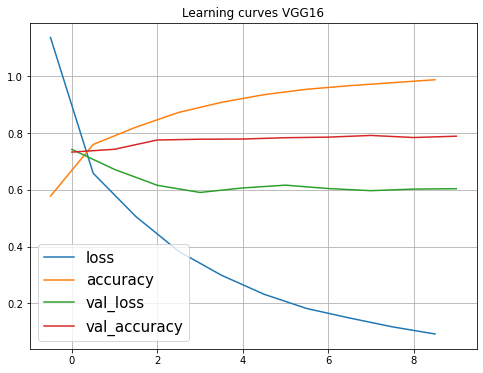

In [31]:
if trainn:
    fig, ax = plt.subplots(figsize=(8,6))

    for metric in history1.history:

        #subtract half epoch from training data<
        if len(metric.split('_')) < 2:
            ax.plot(np.array(history1.epoch)-.5, history1.history[metric], label=metric)
        else:
            ax.plot(history1.epoch, history1.history[metric], label=metric)

    ax.grid()
    ax.set_title('Learning curves VGG16')
    ax.legend(fontsize=15);

Separating the curves of loss from the ones of accuracy.

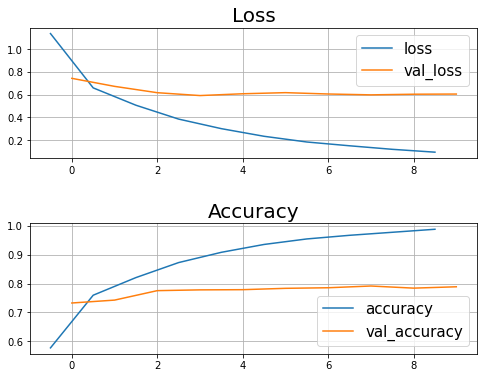

In [32]:
if trainn:
    fig, axs = plt.subplots(2, figsize=(8,6))

    for j, metric in enumerate(history1.history):
        if (j == 0 or j == 2):
            i = 0
        else:
            i = 1
        ax = axs.ravel()[i]
        #subtract half epoch from training data
        if len(metric.split('_')) < 2:
            ax.plot(np.array(history1.epoch)-.5, history1.history[metric], label=metric)
        else:
            ax.plot(history1.epoch, history1.history[metric], label=metric)

    axs[0].grid() 
    axs[1].grid()

    axs[0].legend(fontsize=15)
    axs[0].set_title('Loss', fontsize=20)
    axs[1].legend(fontsize=15)
    axs[1].set_title('Accuracy', fontsize=20)
    plt.subplots_adjust(hspace=0.5)
    fig.savefig('LearningCurves_VGG16.jpg', bbox_inches='tight', dpi=150)

Evaluating the model performance on the test set.

In [33]:
test_loss1, test_accuracy1 = model1.evaluate(test_data0)

1500/1500 [==============================] - 295s 196ms/step - loss: 0.6297 - accuracy: 0.7887


Plotting the confusion matrix to better understand the most frequent errors in data classification.

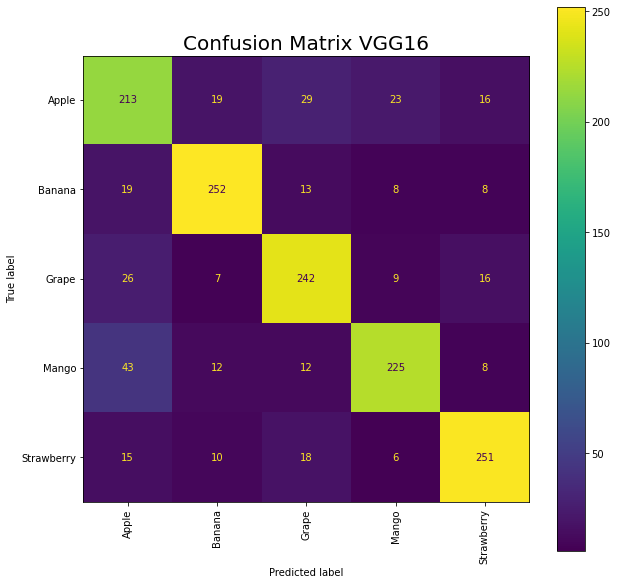

In [34]:
#creating the vectors containing the the predicted labels of the model 
y_pred = model1.predict(test_data0, verbose=0)
y_pred_test = np.argmax(y_pred, axis=1)
y_true_test = np.array([])
for image, label in test_data0.take(-1):
    y_true_test = np.append(y_true_test, label)

#plotting the confusion matrix    
fig, ax = plt.subplots(figsize=(10,10))
cm = skmet.confusion_matrix(y_true=y_true_test, y_pred=y_pred_test)
disp = skmet.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) 
disp.plot(xticks_rotation='vertical', ax=ax)
ax.set_title('Confusion Matrix VGG16', fontsize=20)
plt.show()

Proceeding with the second model, setting the callbacks in this case.

In [35]:
best_w = ModelCheckpoint('FruitClassifier_InceptionV3.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

Setting the optimizer and the loss function, and then the metrics to track during the process of training.

In [36]:
model2.compile(
  optimizer=tf.optimizers.Adam(learning_rate=0.0001),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

Training the second model for the epochs settled.

In [37]:
if trainn:
    if model_save:
        history2 = model2.fit(train_data1,validation_data=validation_data1,epochs=epochs,verbose=1, callbacks=[best_w])
    else:
        history2 = model2.fit(train_data1,validation_data=validation_data1,epochs=epochs,verbose=1)

Epoch 1/10


C:\Users\ASUS\anaconda3\lib\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


55/55 [==============================] - ETA: 0s - loss: 1.6886 - accuracy: 0.6490
Epoch 1: val_accuracy improved from -inf to 0.76533, saving model to FruitClassifier_InceptionV3.h5
55/55 [==============================] - 162s 3s/step - loss: 1.6886 - accuracy: 0.6490 - val_loss: 0.6333 - val_accuracy: 0.7653
Epoch 2/10
55/55 [==============================] - ETA: 0s - loss: 0.5264 - accuracy: 0.8049
Epoch 2: val_accuracy improved from 0.76533 to 0.80400, saving model to FruitClassifier_InceptionV3.h5
55/55 [==============================] - 147s 3s/step - loss: 0.5264 - accuracy: 0.8049 - val_loss: 0.5587 - val_accuracy: 0.8040
Epoch 3/10
55/55 [==============================] - ETA: 0s - loss: 0.3874 - accuracy: 0.8624
Epoch 3: val_accuracy improved from 0.80400 to 0.81867, saving model to FruitClassifier_InceptionV3.h5
55/55 [==============================] - 144s 3s/step - loss: 0.3874 - accuracy: 0.8624 - val_loss: 0.5327 - val_accuracy: 0.8187
Epoch 4/10
55/55 [===============

Plotting learning curves.

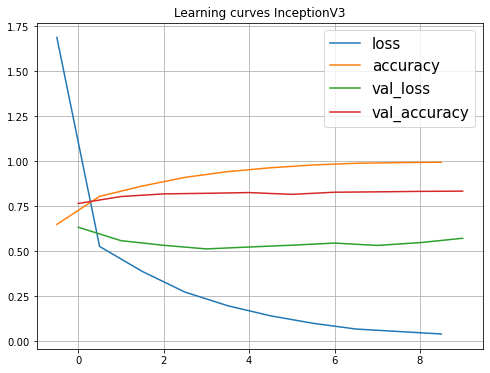

In [38]:
if trainn:
    fig, ax = plt.subplots(figsize=(8,6))

    for metric in history2.history:

        #subtract half epoch from training data<
        if len(metric.split('_')) < 2:
            ax.plot(np.array(history2.epoch)-.5, history2.history[metric], label=metric)
        else:
            ax.plot(history2.epoch, history2.history[metric], label=metric)

    ax.grid()
    ax.set_title('Learning curves InceptionV3')
    ax.legend(fontsize=15);

Separating again loss from accuracy to have a better visualization.

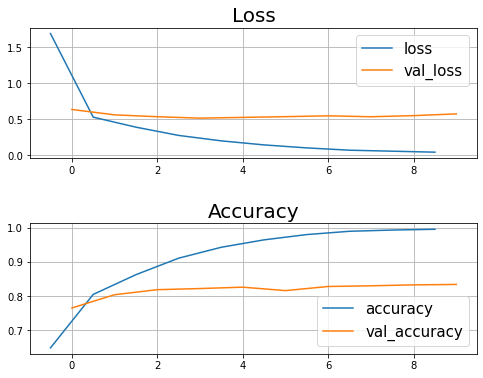

In [39]:
if trainn:
    fig, axs = plt.subplots(2, figsize=(8,6))

    for j, metric in enumerate(history2.history):
        if (j == 0 or j == 2):
            i = 0
        else:
            i = 1
        ax = axs.ravel()[i]
        #subtract half epoch from training data
        if len(metric.split('_')) < 2:
            ax.plot(np.array(history2.epoch)-.5, history2.history[metric], label=metric)
        else:
            ax.plot(history2.epoch, history2.history[metric], label=metric)

    axs[0].grid() 
    axs[1].grid()

    axs[0].legend(fontsize=15)
    axs[0].set_title('Loss', fontsize=20)
    axs[1].legend(fontsize=15)
    axs[1].set_title('Accuracy', fontsize=20)
    plt.subplots_adjust(hspace=0.5)
    fig.savefig('Learningcurves_InceptionV3.jpg', bbox_inches='tight', dpi=150)

Evaluating this model performance on unseen test data

In [40]:
test_loss2, test_accuracy2 = model2.evaluate(test_data1)

1500/1500 [==============================] - 55s 36ms/step - loss: 0.5799 - accuracy: 0.8273


Plotting the confusion matrix in this case.

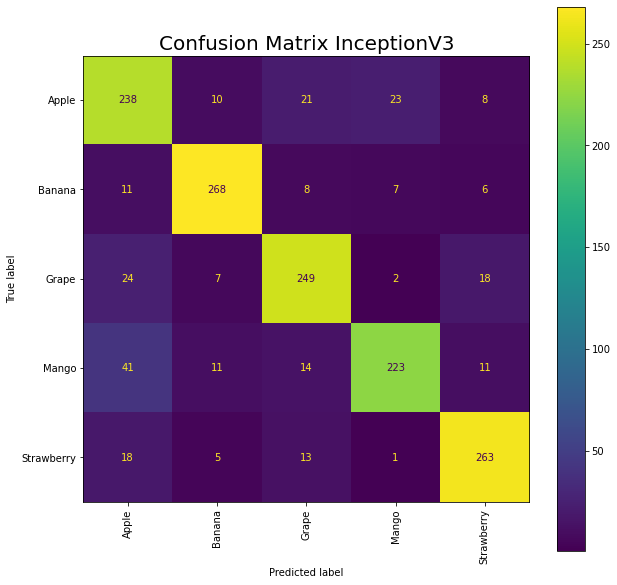

In [41]:
#creating the vectors containing the the predicted labels of the model 
y_pred = model2.predict(test_data1, verbose=0)
y_pred_test = np.argmax(y_pred, axis=1)
y_true_test = np.array([])
for image, label in test_data1.take(-1):
    y_true_test = np.append(y_true_test, label)

#plotting the confusion matrix    
fig, ax = plt.subplots(figsize=(10,10))
cm = skmet.confusion_matrix(y_true=y_true_test, y_pred=y_pred_test)
disp = skmet.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) 
disp.plot(xticks_rotation='vertical', ax=ax)
ax.set_title('Confusion Matrix InceptionV3', fontsize=20)
plt.show()

Setting callbacks for the last model, the _EfficientNetB0_.

In [42]:
best_w = ModelCheckpoint('FruitClassifier_EfficientNetB0.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

Fixing optimizer and loss function for this model.

In [43]:
model3.compile(
  optimizer=tf.optimizers.Adam(learning_rate=0.0001),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

Training _EfficientNetB0_ for the same number as epochs of previous models.

In [44]:
if trainn:
    if model_save:
        history3 = model3.fit(train_data0,validation_data=validation_data0,epochs=epochs,verbose=1, callbacks=[best_w])
    else:
        history3 = model3.fit(train_data0,validation_data=validation_data0,epochs=epochs,verbose=1)

Epoch 1/10


C:\Users\ASUS\anaconda3\lib\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


55/55 [==============================] - ETA: 0s - loss: 0.7169 - accuracy: 0.7770
Epoch 1: val_accuracy improved from -inf to 0.85733, saving model to FruitClassifier_EfficientNetB0.h5
55/55 [==============================] - 345s 6s/step - loss: 0.7169 - accuracy: 0.7770 - val_loss: 0.3847 - val_accuracy: 0.8573
Epoch 2/10
55/55 [==============================] - ETA: 0s - loss: 0.1484 - accuracy: 0.9501
Epoch 2: val_accuracy improved from 0.85733 to 0.86667, saving model to FruitClassifier_EfficientNetB0.h5
55/55 [==============================] - 336s 6s/step - loss: 0.1484 - accuracy: 0.9501 - val_loss: 0.3909 - val_accuracy: 0.8667
Epoch 3/10
55/55 [==============================] - ETA: 0s - loss: 0.0695 - accuracy: 0.9791
Epoch 3: val_accuracy improved from 0.86667 to 0.86933, saving model to FruitClassifier_EfficientNetB0.h5
55/55 [==============================] - 339s 6s/step - loss: 0.0695 - accuracy: 0.9791 - val_loss: 0.4270 - val_accuracy: 0.8693
Epoch 4/10
55/55 [======

Plotting learning curves.

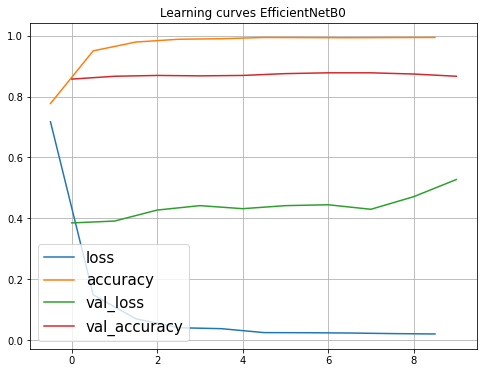

In [45]:
if trainn:
    fig, ax = plt.subplots(figsize=(8,6))

    for metric in history3.history:

        #subtract half epoch from training data<
        if len(metric.split('_')) < 2:
            ax.plot(np.array(history3.epoch)-.5, history3.history[metric], label=metric)
        else:
            ax.plot(history3.epoch, history3.history[metric], label=metric)

    ax.grid()
    ax.set_title('Learning curves EfficientNetB0')
    ax.legend(fontsize=15);

Splitting into two plots accuracy curves and loss ones.

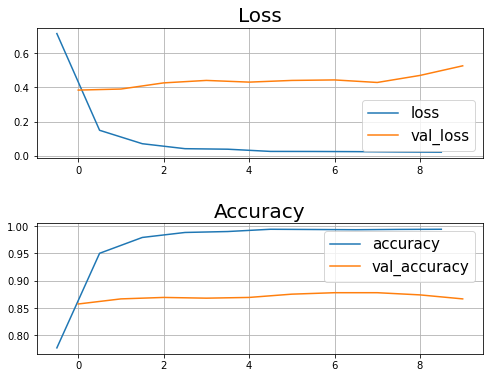

In [46]:
if trainn:
    fig, axs = plt.subplots(2, figsize=(8,6))

    for j, metric in enumerate(history3.history):
        if (j == 0 or j == 2):
            i = 0
        else:
            i = 1
        ax = axs.ravel()[i]
        #subtract half epoch from training data
        if len(metric.split('_')) < 2:
            ax.plot(np.array(history3.epoch)-.5, history3.history[metric], label=metric)
        else:
            ax.plot(history3.epoch, history3.history[metric], label=metric)

    axs[0].grid() 
    axs[1].grid()

    axs[0].legend(fontsize=15)
    axs[0].set_title('Loss', fontsize=20)
    axs[1].legend(fontsize=15)
    axs[1].set_title('Accuracy', fontsize=20)
    plt.subplots_adjust(hspace=0.5)
    fig.savefig('Learningcurves_EfficientNetB0.jpg', bbox_inches='tight', dpi=150)

Evaluating the test performance of this last model.

In [47]:
test_loss3, test_accuracy3 = model3.evaluate(test_data0)

1500/1500 [==============================] - 96s 64ms/step - loss: 0.5740 - accuracy: 0.8740


Visualizing the confusion matrix once again.

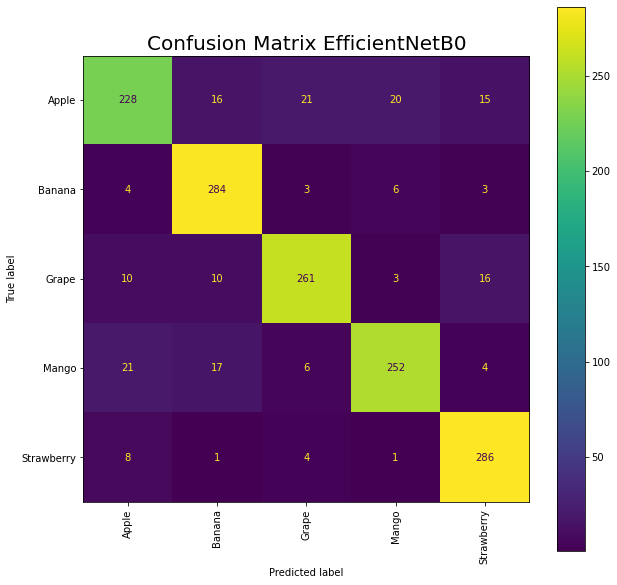

In [48]:
#creating the vectors containing the the predicted labels of the model 
y_pred = model3.predict(test_data0, verbose=0)
y_pred_test = np.argmax(y_pred, axis=1)
y_true_test = np.array([])
for image, label in test_data0.take(-1):
    y_true_test = np.append(y_true_test, label)

#plotting the confusion matrix    
fig, ax = plt.subplots(figsize=(10,10))
cm = skmet.confusion_matrix(y_true=y_true_test, y_pred=y_pred_test)
disp = skmet.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) 
disp.plot(xticks_rotation='vertical', ax=ax)
ax.set_title('Confusion Matrix EfficientNetB0', fontsize=20)
plt.show()

## Conclusions

Plotting the learning curves of the 3 different models together, in order to confrontate them

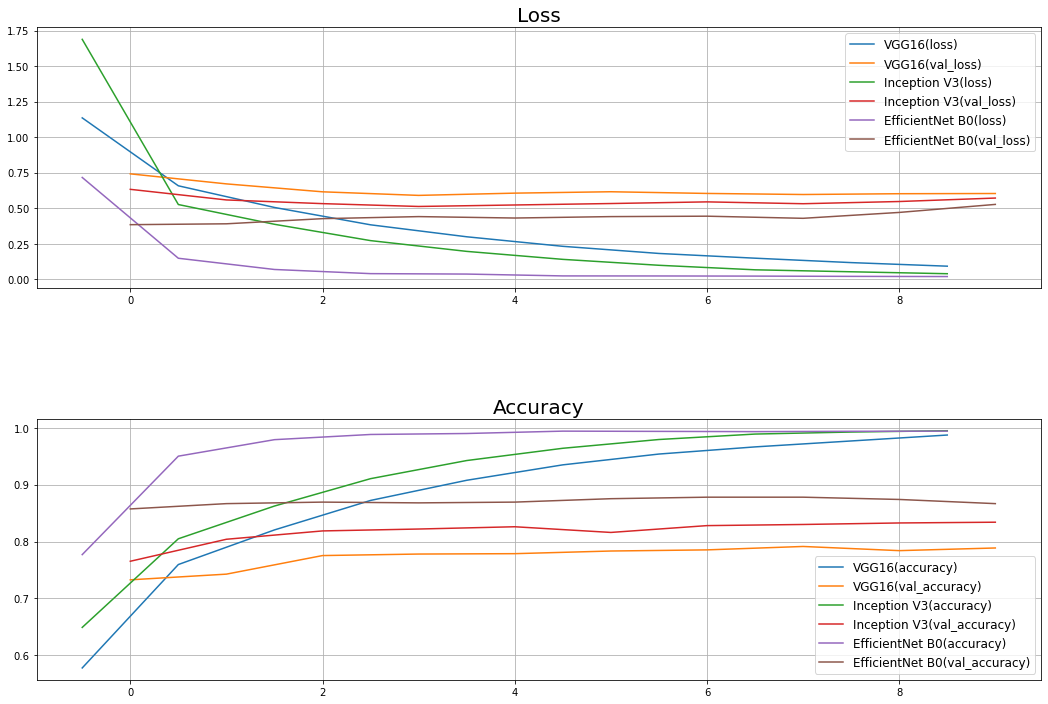

In [79]:
if trainn:
    fig, axs = plt.subplots(2, figsize=(18,12))
    histories = [history1, history2, history3]
    names = ['VGG16', "Inception V3", "EfficientNet B0"]
    k = 0
    for i,history in enumerate(histories):
        for j, metric in enumerate(history.history):
            if (j == 0 or j == 2):
                i = 0
            else:
                i = 1
            ax = axs.ravel()[i]
            #subtract half epoch from training data
            if len(metric.split('_')) < 2:
                ax.plot(np.array(history.epoch)-.5, history.history[metric], label=f'{names[k]}({metric})')
            else:
                ax.plot(history.epoch, history.history[metric], label=f'{names[k]}({metric})')
        k+=1

    axs[0].grid() 
    axs[1].grid()

    axs[0].legend(fontsize=12, loc='best')
    axs[0].set_title('Loss', fontsize=20)
    axs[1].legend(fontsize=12, loc='best')
    axs[1].set_title('Accuracy', fontsize=20)
    plt.subplots_adjust(hspace=0.5)
    fig.savefig('Learningcurves.jpg', bbox_inches='tight', dpi=150)

Summarizing performance of the models in a table.

In [50]:
models = ['VGG16', "Inception V3", "EfficientNet B0"]

# Aggiunta delle righe con i valori
results = pd.DataFrame([(models[0], test_accuracy1),(models[1], test_accuracy2),(models[2], test_accuracy3)], columns=['Models', 'Test Accuracy[%]'])

results.set_index('Models', inplace=True)
# Mostrare la tabella
results

,Test Accuracy[%]
Models,
VGG16,0.788667
Inception V3,0.827333
EfficientNet B0,0.874000


Finding in _EfficientNetB0_ the best model, for performance on the test set and computational cost.

Trying to define a more efficient structure for improving performance and using data augmentation to reduce overfitting.


In [51]:
tf.keras.backend.clear_session()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

base_model = efn.EfficientNetB0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False


inputs = Input(shape=(224, 224, 3))

x = RandomRotation(0.3)(inputs)

x = RandomContrast(0.5)(x)

x = RandomZoom(0.25)(x)

x = Rescaling(1./255)(x)

x = base_model(x)

x = GlobalAveragePooling2D(name="avg_pool")(x)

x = BatchNormalization()(x)

x = Dense(512, activation='relu')(x)

x = Dropout(0.5, name="top_dropout")(x)

x = Dense(256, activation='relu')(x)

x = Dropout(0.4)(x)
# Add a final sigmoid layer with 1 node for classification output
output = Dense(n_classes, activation='softmax', name='OutputLayer')(x)


final_model = tf.keras.models.Model(inputs=inputs, outputs=output)

final_model.summary(show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         Y          
                                                                            
 random_rotation (RandomRota  (None, 224, 224, 3)      0         Y          
 tion)                                                                      
                                                                            
 random_contrast (RandomCont  (None, 224, 224, 3)      0         Y          
 rast)                                                                      
                                                                            
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         Y          
                                                                            
 rescaling (Rescaling)       (None, 224, 224, 3)       0     

Re-defining data because for image augmentation the model need the real value of pixels, to be resized further during training

In [52]:
train_data = tf.keras.utils.image_dataset_from_directory(train_path, seed=123, image_size=im_size[0], batch_size=batch_size)
validation_data = tf.keras.utils.image_dataset_from_directory(val_path, seed=123, image_size=im_size[0], batch_size=batch_size)
test_data = tf.keras.utils.image_dataset_from_directory(test_path, image_size=im_size[0], batch_size=1, shuffle=False)

Found 7000 files belonging to 5 classes.
Found 1500 files belonging to 5 classes.
Found 1500 files belonging to 5 classes.


Resetting the model callbacks for the final save of the model

In [53]:
model_save = True
best_w = ModelCheckpoint('Fruit_Classifier_v_EfficientNet_final_3aug.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

Resetting optimizers and loss function

In [54]:
final_model.compile(
  optimizer=tf.optimizers.Adam(learning_rate=0.001),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

Finally training the new model structure

In [55]:
trainn = False
if trainn == False:
    final_model.load_weights('Fruit_Classifier_v_EfficientNet_final_3aug.h5')

In [56]:
if trainn:
    epochs = 15

    if model_save:
        history_final = final_model.fit(train_data,validation_data=validation_data,epochs=epochs,verbose=1, callbacks=[best_w])
    else:
        history_final = final_model.fit(train_data,validation_data=validation_data,epochs=epochs,verbose=1)

Epoch 1/15


C:\Users\ASUS\anaconda3\lib\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


55/55 [==============================] - ETA: 0s - loss: 1.0082 - accuracy: 0.6401
Epoch 1: val_accuracy improved from -inf to 0.82800, saving model to Fruit_Classifier_v_EfficientNet_final_3aug.h5
55/55 [==============================] - 378s 7s/step - loss: 1.0082 - accuracy: 0.6401 - val_loss: 0.6696 - val_accuracy: 0.8280
Epoch 2/15
55/55 [==============================] - ETA: 0s - loss: 0.6862 - accuracy: 0.7507
Epoch 2: val_accuracy improved from 0.82800 to 0.84867, saving model to Fruit_Classifier_v_EfficientNet_final_3aug.h5
55/55 [==============================] - 373s 7s/step - loss: 0.6862 - accuracy: 0.7507 - val_loss: 0.5405 - val_accuracy: 0.8487
Epoch 3/15
55/55 [==============================] - ETA: 0s - loss: 0.6156 - accuracy: 0.7669
Epoch 3: val_accuracy improved from 0.84867 to 0.85667, saving model to Fruit_Classifier_v_EfficientNet_final_3aug.h5
55/55 [==============================] - 369s 7s/step - loss: 0.6156 - accuracy: 0.7669 - val_loss: 0.4616 - val_accur

Plotting results.

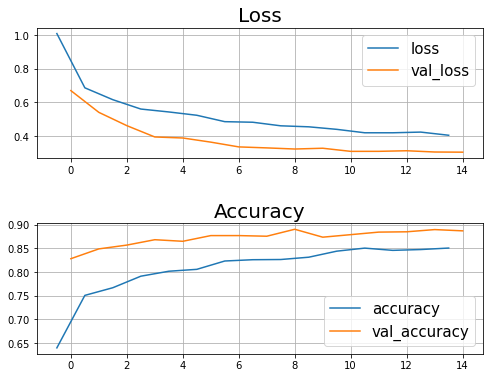

In [57]:
if trainn:
    fig, axs = plt.subplots(2, figsize=(8,6))

    for j, metric in enumerate(history_final.history):
        if (j == 0 or j == 2):
            i = 0
        else:
            i = 1
        ax = axs.ravel()[i]
        #subtract half epoch from training data
        if len(metric.split('_')) < 2:
            ax.plot(np.array(history_final.epoch)-.5, history_final.history[metric], label=metric)
        else:
            ax.plot(history_final.epoch, history_final.history[metric], label=metric)

    axs[0].grid() 
    axs[1].grid()

    axs[0].legend(fontsize=15)
    axs[0].set_title('Loss', fontsize=20)
    axs[1].legend(fontsize=15)
    axs[1].set_title('Accuracy', fontsize=20)
    plt.subplots_adjust(hspace=0.5)
    fig.savefig('LearningcurvesEfficientNetB0Final_3aug.jpg', bbox_inches='tight', dpi=150)

Evaluating the performance of the model, the learning curves show better behaviour and similar validation and train trends, so this result must be more confident.

In [58]:
test_loss_final, test_accuracy_final = final_model.evaluate(test_data)

1500/1500 [==============================] - 108s 72ms/step - loss: 0.3239 - accuracy: 0.8907


Showing again model errors

1500/1500 [==============================] - 111s 72ms/step


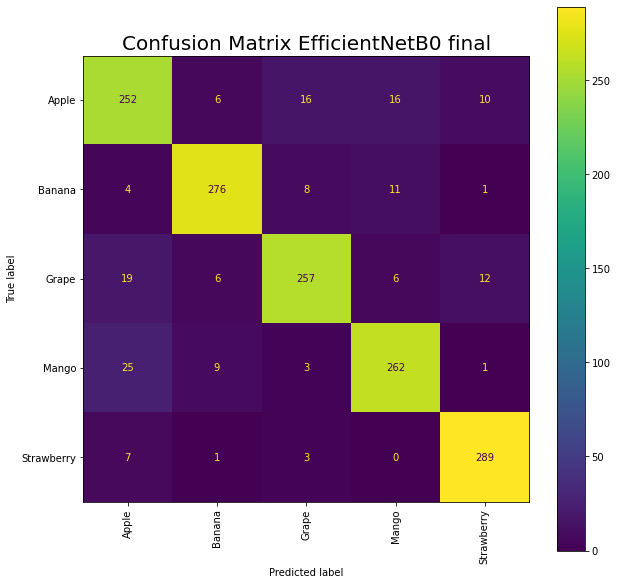

<Figure size 432x288 with 0 Axes>

In [59]:
#creating the vectors containing the the predicted labels of the model 
y_pred = final_model.predict(test_data, verbose=1)
y_pred_test = np.argmax(y_pred, axis=1)
y_true_test = np.array([])
for image, label in test_data0.take(-1):
    y_true_test = np.append(y_true_test, label)

#plotting the confusion matrix    
fig, ax = plt.subplots(figsize=(10,10))
cm = skmet.confusion_matrix(y_true=y_true_test, y_pred=y_pred_test)
disp = skmet.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) 
disp.plot(xticks_rotation='vertical', ax=ax)
ax.set_title('Confusion Matrix EfficientNetB0 final', fontsize=20)
plt.show()
plt.savefig('Confusion Matrix EfficientNetB0 final')

## Fine tuning

Trying a last approach to improve model performance on test set, unfreezing some of _EfficientNetB0_ last blocks and performing fine-tuning also on these.

In [60]:
tf.keras.backend.clear_session()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

base_model = efn.EfficientNetB0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
base_model.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 112, 112, 32  128         ['stem_conv[0][0]']              
                                )                                                   

 ivation)                                                                                         
                                                                                                  
 block2b_dwconv (DepthwiseConv2  (None, 56, 56, 144)  1296       ['block2b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2b_bn (BatchNormalization  (None, 56, 56, 144)  576        ['block2b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2b_activation (Activation  (None, 56, 56, 144)  0          ['block2b_bn[0][0]']             
 )                                                                                                
          

                                                                                                  
 block3b_se_squeeze (GlobalAver  (None, 240)         0           ['block3b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3b_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block3b_se_squeeze[0][0]']     
                                                                                                  
 block3b_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block3b_se_reshape[0][0]']     
                                                                                                  
 block3b_se_expand (Conv2D)     (None, 1, 1, 240)    2640        ['block3b_se_reduce[0][0]']      
                                                                                                  
 block3b_s

 block4b_se_excite (Multiply)   (None, 14, 14, 480)  0           ['block4b_activation[0][0]',     
                                                                  'block4b_se_expand[0][0]']      
                                                                                                  
 block4b_project_conv (Conv2D)  (None, 14, 14, 80)   38400       ['block4b_se_excite[0][0]']      
                                                                                                  
 block4b_project_bn (BatchNorma  (None, 14, 14, 80)  320         ['block4b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4b_drop (FixedDropout)    (None, 14, 14, 80)   0           ['block4b_project_bn[0][0]']     
                                                                                                  
 block4b_a

 block5a_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5b_expand_conv (Conv2D)   (None, 14, 14, 672)  75264       ['block5a_project_bn[0][0]']     
                                                                                                  
 block5b_expand_bn (BatchNormal  (None, 14, 14, 672)  2688       ['block5b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5b_expand_activation (Act  (None, 14, 14, 672)  0          ['block5b_expand_bn[0][0]']      
 ivation)                                                                                         
          

 block6a_expand_bn (BatchNormal  (None, 14, 14, 672)  2688       ['block6a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6a_expand_activation (Act  (None, 14, 14, 672)  0          ['block6a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6a_dwconv (DepthwiseConv2  (None, 7, 7, 672)   16800       ['block6a_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6a_bn (BatchNormalization  (None, 7, 7, 672)   2688        ['block6a_dwconv[0][0]']         
 )        

 )                                                                                                
                                                                                                  
 block6c_activation (Activation  (None, 7, 7, 1152)  0           ['block6c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6c_se_squeeze (GlobalAver  (None, 1152)        0           ['block6c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6c_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block6c_se_squeeze[0][0]']     
                                                                                                  
 block6c_s

 block7a_se_squeeze (GlobalAver  (None, 1152)        0           ['block7a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block7a_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block7a_se_squeeze[0][0]']     
                                                                                                  
 block7a_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block7a_se_reshape[0][0]']     
                                                                                                  
 block7a_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block7a_se_reduce[0][0]']      
                                                                                                  
 block7a_se_excite (Multiply)   (None, 7, 7, 1152)   0           ['block7a_activation[0][0]',     
          

Setting which block to keep unfreezed during training, _block_name_ will set this hyperparameter.

In [61]:
block_name = 'block7a_expand_conv'
trainable_index = None
for i, layer in enumerate(base_model.layers):
    if block_name in layer.name:
        trainable_index = i
        break

# Set the layers before the identified block to be non-trainable
for layer in base_model.layers[:trainable_index]:
    layer.trainable = False

# Set the layers from the identified block onwards to be trainable
for layer in base_model.layers[trainable_index:]:
    layer.trainable = True
base_model.summary(show_trainable=True)

Model: "efficientnet-b0"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               N          
                                )]                                                                           
                                                                                                             
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['input_1[0][0]']                N          
                                )                                                                            
                                                                                                             
 stem_bn (BatchNormalization)   (None, 112, 112, 32  128         ['stem_conv[0][0]']           

 lization)                                                                                                   
                                                                                                             
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     N          
                                                                                                             
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    N          
 ization)                                                                                                    
                                                                                                             
 block2b_expand_activation (Act  (None, 56, 56, 144)  0          ['block2b_expand_bn[0][0]']      N          
 ivation)                                                                                                    
          

 block3b_expand_conv (Conv2D)   (None, 28, 28, 240)  9600        ['block3a_project_bn[0][0]']     N          
                                                                                                             
 block3b_expand_bn (BatchNormal  (None, 28, 28, 240)  960        ['block3b_expand_conv[0][0]']    N          
 ization)                                                                                                    
                                                                                                             
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      N          
 ivation)                                                                                                    
                                                                                                             
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][  N          
 D)       

 block4b_expand_bn (BatchNormal  (None, 14, 14, 480)  1920       ['block4b_expand_conv[0][0]']    N          
 ization)                                                                                                    
                                                                                                             
 block4b_expand_activation (Act  (None, 14, 14, 480)  0          ['block4b_expand_bn[0][0]']      N          
 ivation)                                                                                                    
                                                                                                             
 block4b_dwconv (DepthwiseConv2  (None, 14, 14, 480)  4320       ['block4b_expand_activation[0][  N          
 D)                                                              0]']                                        
                                                                                                             
 block4b_b

                                                                                                             
 block5a_expand_conv (Conv2D)   (None, 14, 14, 480)  38400       ['block4c_add[0][0]']            N          
                                                                                                             
 block5a_expand_bn (BatchNormal  (None, 14, 14, 480)  1920       ['block5a_expand_conv[0][0]']    N          
 ization)                                                                                                    
                                                                                                             
 block5a_expand_activation (Act  (None, 14, 14, 480)  0          ['block5a_expand_bn[0][0]']      N          
 ivation)                                                                                                    
                                                                                                             
 block5a_d

                                                                                                             
 block5c_expand_bn (BatchNormal  (None, 14, 14, 672)  2688       ['block5c_expand_conv[0][0]']    N          
 ization)                                                                                                    
                                                                                                             
 block5c_expand_activation (Act  (None, 14, 14, 672)  0          ['block5c_expand_bn[0][0]']      N          
 ivation)                                                                                                    
                                                                                                             
 block5c_dwconv (DepthwiseConv2  (None, 14, 14, 672)  16800      ['block5c_expand_activation[0][  N          
 D)                                                              0]']                                        
          

 ization)                                                                                                    
                                                                                                             
 block6b_expand_activation (Act  (None, 7, 7, 1152)  0           ['block6b_expand_bn[0][0]']      N          
 ivation)                                                                                                    
                                                                                                             
 block6b_dwconv (DepthwiseConv2  (None, 7, 7, 1152)  28800       ['block6b_expand_activation[0][  N          
 D)                                                              0]']                                        
                                                                                                             
 block6b_bn (BatchNormalization  (None, 7, 7, 1152)  4608        ['block6b_dwconv[0][0]']         N          
 )        

 block6d_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6c_add[0][0]']            N          
                                                                                                             
 block6d_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6d_expand_conv[0][0]']    N          
 ization)                                                                                                    
                                                                                                             
 block6d_expand_activation (Act  (None, 7, 7, 1152)  0           ['block6d_expand_bn[0][0]']      N          
 ivation)                                                                                                    
                                                                                                             
 block6d_dwconv (DepthwiseConv2  (None, 7, 7, 1152)  28800       ['block6d_expand_activation[0][  N          
 D)       

 top_bn (BatchNormalization)    (None, 7, 7, 1280)   5120        ['top_conv[0][0]']               Y          
                                                                                                             
 top_activation (Activation)    (None, 7, 7, 1280)   0           ['top_bn[0][0]']                 Y          
                                                                                                             
Total params: 4,049,564
Trainable params: 1,129,392
Non-trainable params: 2,920,172
_____________________________________________________________________________________________________________


Keeping data augmentation layers and adding the usual layers to the _base_model_ previous definited.

In [62]:
inputs = Input(shape=(224, 224, 3))

x = RandomRotation(0.3)(inputs)

x = RandomContrast(0.5)(x)

x = Rescaling(1./255)(x)

x = base_model(x)

x = GlobalAveragePooling2D(name="avg_pool")(x)

x = BatchNormalization()(x)

x = Dense(256, activation='relu')(x)

x = Dropout(0.4)(x)
# Add a final sigmoid layer with 1 node for classification output
output = Dense(n_classes, activation='softmax', name='OutputLayer')(x)


final_model_ft = tf.keras.models.Model(name='EfficientNetB0_fine_tuning', inputs=inputs, outputs=output)

final_model_ft.summary(show_trainable=True)

Model: "EfficientNetB0_fine_tuning"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         Y          
                                                                            
 random_rotation (RandomRota  (None, 224, 224, 3)      0         Y          
 tion)                                                                      
                                                                            
 random_contrast (RandomCont  (None, 224, 224, 3)      0         Y          
 rast)                                                                      
                                                                            
 rescaling (Rescaling)       (None, 224, 224, 3)       0         Y          
                                                                            
 efficientnet-b0 (Functional  (None, 7, 

Setting callbacks for saving model weights.

In [63]:
model_save = True
best_w = ModelCheckpoint('Fruit_Classifier_v_EfficientNet_fine_tuning_7a.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

Resetting optimizers and loss function.

In [64]:
final_model_ft.compile(
  optimizer=tf.optimizers.Adam(learning_rate=0.001),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

Choosing if train or load already trained weights.


In [65]:
trainn = False
if trainn == False:
    final_model_ft.load_weights('Fruit_Classifier_v_EfficientNet_fine_tuning_7a.h5')

Finally training the model.

In [66]:
if trainn:
    epochs = 15

    if model_save:
        history_final_ft = final_model_ft.fit(train_data,validation_data=validation_data,epochs=epochs,verbose=1, callbacks=[best_w])
    else:
        history_final_ft = final_model_ft.fit(train_data,validation_data=validation_data,epochs=epochs,verbose=1)

Epoch 1/15


C:\Users\ASUS\anaconda3\lib\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


55/55 [==============================] - ETA: 0s - loss: 0.7948 - accuracy: 0.7417
Epoch 1: val_accuracy improved from -inf to 0.87133, saving model to Fruit_Classifier_v_EfficientNet_fine_tuning_7a.h5
55/55 [==============================] - 445s 8s/step - loss: 0.7948 - accuracy: 0.7417 - val_loss: 0.3962 - val_accuracy: 0.8713
Epoch 2/15
55/55 [==============================] - ETA: 0s - loss: 0.3965 - accuracy: 0.8594
Epoch 2: val_accuracy improved from 0.87133 to 0.89467, saving model to Fruit_Classifier_v_EfficientNet_fine_tuning_7a.h5
55/55 [==============================] - 441s 8s/step - loss: 0.3965 - accuracy: 0.8594 - val_loss: 0.3098 - val_accuracy: 0.8947
Epoch 3/15
55/55 [==============================] - ETA: 0s - loss: 0.3177 - accuracy: 0.8850
Epoch 3: val_accuracy improved from 0.89467 to 0.90533, saving model to Fruit_Classifier_v_EfficientNet_fine_tuning_7a.h5
55/55 [==============================] - 451s 8s/step - loss: 0.3177 - accuracy: 0.8850 - val_loss: 0.2890

Plotting results.

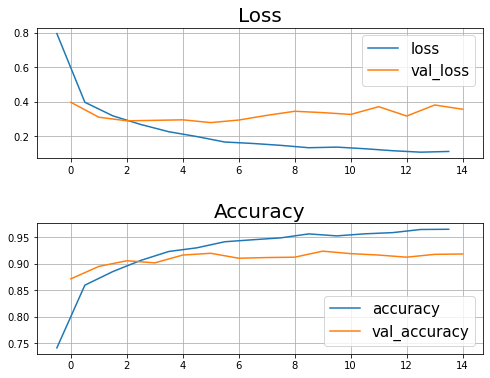

In [67]:
if trainn:
    fig, axs = plt.subplots(2, figsize=(8,6))

    for j, metric in enumerate(history_final_ft.history):
        if (j == 0 or j == 2):
            i = 0
        else:
            i = 1
        ax = axs.ravel()[i]
        #subtract half epoch from training data
        if len(metric.split('_')) < 2:
            ax.plot(np.array(history_final_ft.epoch)-.5, history_final_ft.history[metric], label=metric)
        else:
            ax.plot(history_final_ft.epoch, history_final_ft.history[metric], label=metric)

    axs[0].grid() 
    axs[1].grid()

    axs[0].legend(fontsize=15)
    axs[0].set_title('Loss', fontsize=20)
    axs[1].legend(fontsize=15)
    axs[1].set_title('Accuracy', fontsize=20)
    plt.subplots_adjust(hspace=0.5)
    fig.savefig('LearningcurvesEfficientNetB0fine_tuning.jpg', bbox_inches='tight', dpi=150)

Evaluating the performance of the model, the learning curves show really similar trends in respect with the data augmentation version, with also a higher validation accuracy.

Checking this model prediction on test set to get the final score.

In [68]:
test_loss_final_ft, test_accuracy_final_ft = final_model_ft.evaluate(test_data)

1500/1500 [==============================] - 140s 93ms/step - loss: 0.4151 - accuracy: 0.9233


The test accuracy is the best seen, showing however model errors with a confusion matrix.

1500/1500 [==============================] - 134s 88ms/step


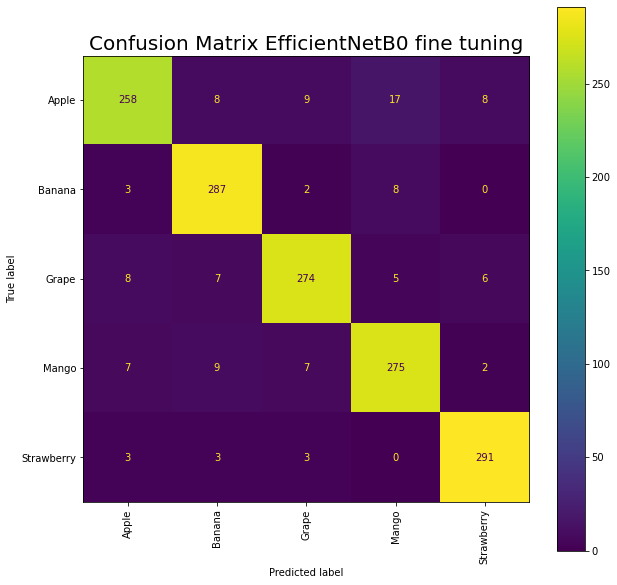

<Figure size 432x288 with 0 Axes>

In [69]:
#creating the vectors containing the the predicted labels of the model 
y_pred = final_model_ft.predict(test_data, verbose=1)
y_pred_test = np.argmax(y_pred, axis=1)
y_true_test = np.array([])
for image, label in test_data0.take(-1):
    y_true_test = np.append(y_true_test, label)

#plotting the confusion matrix    
fig, ax = plt.subplots(figsize=(10,10))
cm = skmet.confusion_matrix(y_true=y_true_test, y_pred=y_pred_test)
disp = skmet.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) 
disp.plot(xticks_rotation='vertical', ax=ax)
ax.set_title('Confusion Matrix EfficientNetB0 fine tuning', fontsize=20)
plt.show()
plt.savefig('Confusion Matrix final fine tuning')